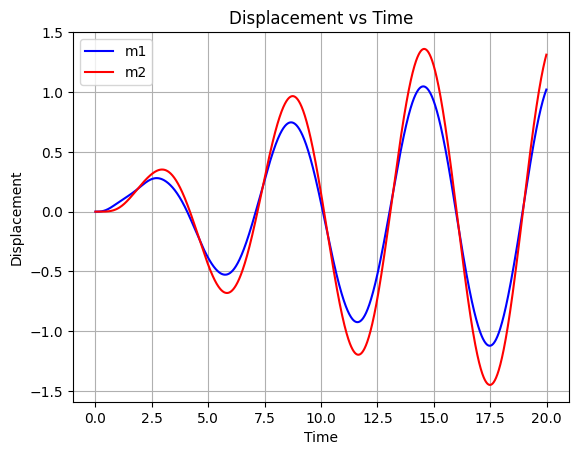

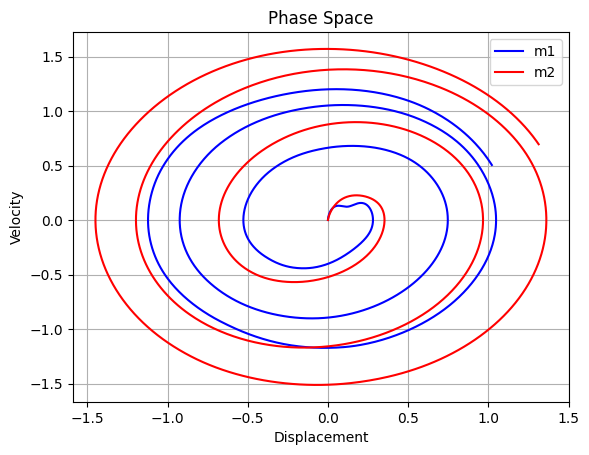

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define system parameters
m1 = 1       # Mass of the first mass
m2 = 2       # Mass of the second mass
k1 = 5       # Spring constant of the first spring
k2 = 10      # Spring constant of the second spring
c = 0.5      # Damping coefficient
F = lambda t: np.sin(t)  # External force function

# Define initial conditions
x0 = [0, 0]  # Initial displacement of the masses
v0 = [0, 0]  # Initial velocity of the masses
y0 = x0 + v0  # Initial state of the system

# Define time span and time step
tspan = (0, 20)  # Simulation time span
dt = 0.01        # Time step
t_eval = np.arange(tspan[0], tspan[1], dt)

# Define the system dynamics function
def dynamics(t, y):
    return [
        y[2],
        y[3],
        (F(t) - k1 * y[0] - k2 * (y[0] - y[1]) - c * (y[2] - y[3])) / m1,
        (k2 * (y[0] - y[1]) + c * (y[2] - y[3])) / m2
    ]

# Solve the system using solve_ivp
solution = solve_ivp(dynamics, tspan, y0, t_eval=t_eval)
t = solution.t
y = solution.y

# Plot the results
plt.figure()
plt.plot(t, y[0, :], 'b-', label='m1')
plt.plot(t, y[1, :], 'r-', label='m2')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.title('Displacement vs Time')
plt.grid()

plt.figure()
plt.plot(y[0, :], y[2, :], 'b-', label='m1')
plt.plot(y[1, :], y[3, :], 'r-', label='m2')
plt.xlabel('Displacement')
plt.ylabel('Velocity')
plt.legend()
plt.title('Phase Space')
plt.grid()

plt.show()


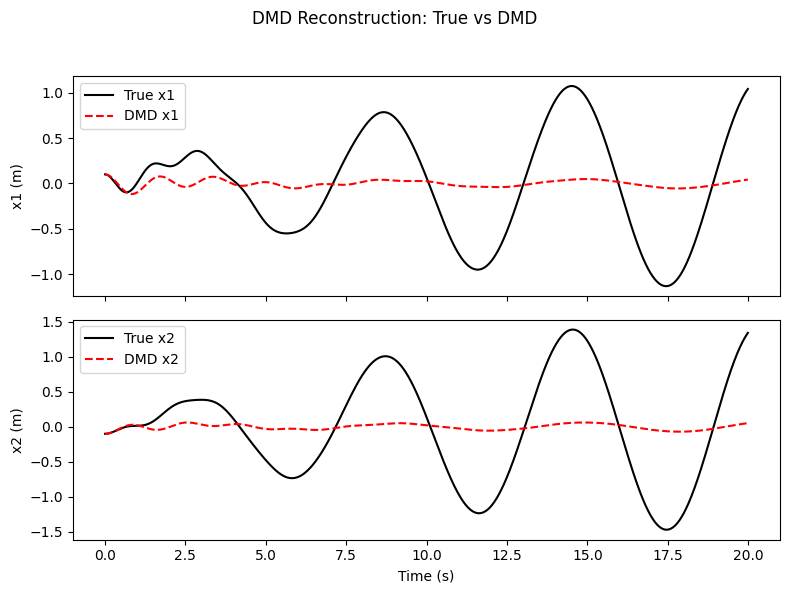

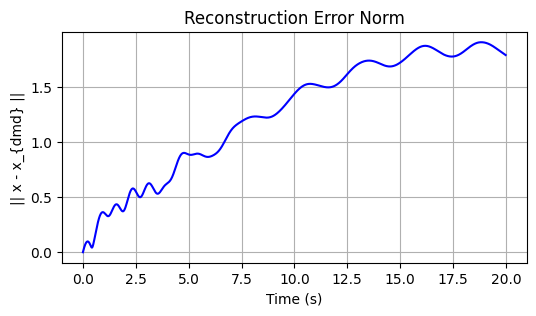

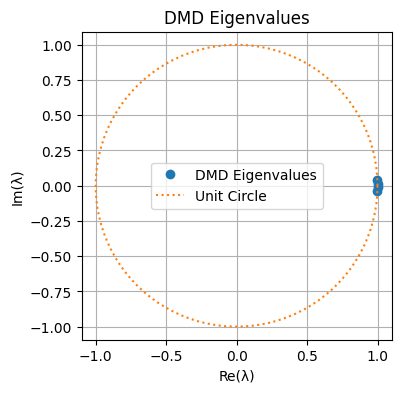

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
m1, m2 = 1.0, 2.0
k1, k2 = 5.0, 10.0
c = 0.5
F = lambda t: np.sin(t)

# Time settings
dt      = 0.01
t_final = 20.0
t       = np.arange(0, t_final, dt)

# Initial conditions (modifiable)
x1_0, x2_0, v1_0, v2_0 = 0.1, -0.1, 0.0, 0.0
y0 = [x1_0, x2_0, v1_0, v2_0]

# Dynamics for data generation
def dynamics(t, y):
    x1, x2, v1, v2 = y
    dx1 = v1
    dx2 = v2
    dv1 = (F(t) - k1*x1 - k2*(x1 - x2) - c*(v1 - v2)) / m1
    dv2 = (    k2*(x1 - x2) + c*(v1 - v2)) / m2
    return [dx1, dx2, dv1, dv2]

# Generate true data
sol = solve_ivp(dynamics, [0, t_final], y0, t_eval=t)
X = sol.y  # (4, N)

# Build DMD snapshot matrices
X1 = X[:, :-1]
X2 = X[:, 1:]

# SVD and rank truncation
U, S, Vh = np.linalg.svd(X1, full_matrices=False)
r = 4
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh.conj().T[:, :r]

# Reduced A matrix
A_tilde = Ur.T @ X2 @ Vr @ np.linalg.inv(Sr)
eigvals, W = np.linalg.eig(A_tilde)
Phi = X2 @ Vr @ np.linalg.inv(Sr) @ W

# Mode amplitudes
x0_snap = X1[:, 0]
b = np.linalg.lstsq(Phi, x0_snap, rcond=None)[0]

# Time evolution
omega = np.log(eigvals) / dt
time_dynamics = np.exp(np.outer(omega, t))

# DMD reconstruction
X_dmd = (Phi @ (b[:, None] * time_dynamics)).real

# ---- Plots ----
# 1. True vs DMD reconstruction for x1 and x2
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
axs[0].plot(t, X[0],    'k',  label='True x1')
axs[0].plot(t, X_dmd[0],'r--', label='DMD x1')
axs[0].set_ylabel('x1 (m)')
axs[0].legend()
axs[1].plot(t, X[1],    'k',  label='True x2')
axs[1].plot(t, X_dmd[1],'r--', label='DMD x2')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('x2 (m)')
axs[1].legend()
fig.suptitle('DMD Reconstruction: True vs DMD')
plt.tight_layout(rect=[0,0,1,0.95])

# 2. Reconstruction error norm over time
error = np.linalg.norm(X - X_dmd, axis=0)
plt.figure(figsize=(6,3))
plt.plot(t, error, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('|| x - x_{dmd} ||')
plt.title('Reconstruction Error Norm')
plt.grid()

# 3. DMD eigenvalues on complex plane
plt.figure(figsize=(4,4))
plt.plot(np.real(eigvals), np.imag(eigvals), 'o', label='DMD Eigenvalues')
theta = np.linspace(0,2*np.pi,100)
plt.plot(np.cos(theta), np.sin(theta), ':', label='Unit Circle')
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title('DMD Eigenvalues')
plt.axis('equal')
plt.legend()
plt.grid()

plt.show()


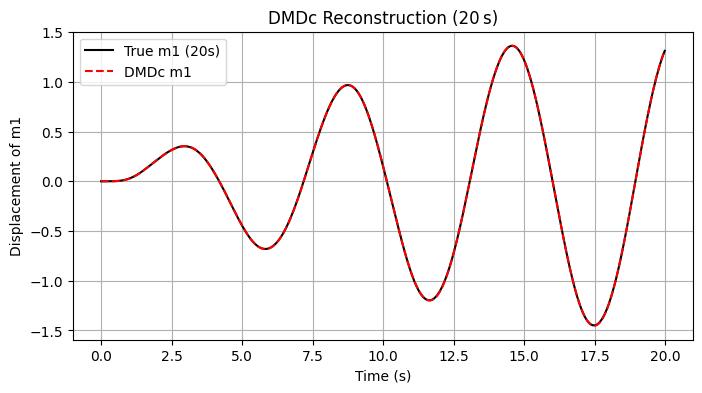

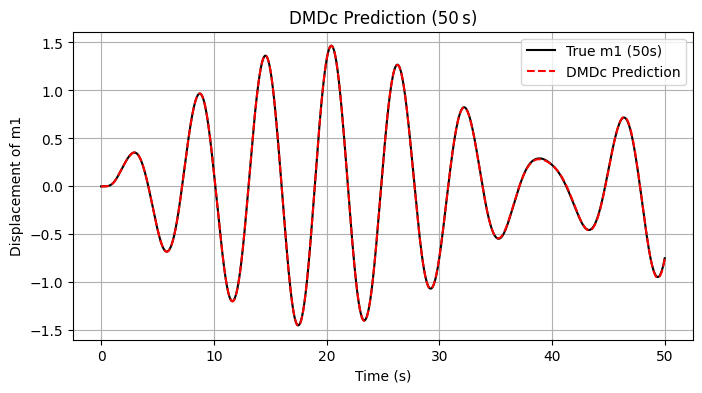

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
m1, m2 = 1.0, 2.0
k1, k2 = 5.0, 10.0
c = 0.5

# State‑space matrices
A = np.array([
    [0, 0,               1,      0],
    [0, 0,               0,      1],
    [-(k1+k2)/m1,  k2/m1, -c/m1,  c/m1],
    [ k2/m2,     -k2/m2,  c/m2, -c/m2]
])
B = np.array([[0], [0], [0], [1/m2]])

# Forcing function
F = lambda t: np.sin(t)

# Time vectors
dt       = 0.01
t_recon  = np.arange(0, 20, dt)
t_full   = np.arange(0, 50, dt)
y0       = [0, 0, 0, 0]  # initial [x1, x2, v1, v2]

# Wrapper for solve_ivp
def dynamics(t, y):
    return A.dot(y) + B.flatten() * F(t)

# 1) Simulate true dynamics for 20s
sol = solve_ivp(dynamics, [0, 20], y0, t_eval=t_recon)
X   = sol.y          # shape (4, N)
U   = F(t_recon)     # shape (N,)

# 2) Build snapshot matrices
X1 = X[:, :-1]           # columns 0..N-2
X2 = X[:, 1:]            # columns 1..N-1
U1 = U[:-1][None, :]     # row vector (1, N-1)

# 3) Form augmented data and solve for A_dmd, B_dmd
Z    = np.vstack([X1, U1])   # (5, N-1)
G    = X2.dot(np.linalg.pinv(Z))
A_dmd = G[:, :4]
B_dmd = G[:, 4:]

# 4) Reconstruct over 20s
X_dmd = np.zeros_like(X)
X_dmd[:, 0] = X[:, 0]
for k in range(X.shape[1] - 1):
    X_dmd[:, k+1] = A_dmd.dot(X_dmd[:, k]) + B_dmd.flatten() * U[k]

# 5) Predict out to 50s
X_pred = np.zeros((4, t_full.size))
X_pred[:, 0] = X[:, 0]
u_full = F(t_full)
for k in range(t_full.size - 1):
    X_pred[:, k+1] = A_dmd.dot(X_pred[:, k]) + B_dmd.flatten() * u_full[k]

# 6) Plot results
# Reconstruction (20s)
plt.figure(figsize=(8,4))
plt.plot(t_recon, X[0],    'k-',  label='True m1 (20s)')
plt.plot(t_recon, X_dmd[0], 'r--', label='DMDc m1')
plt.xlabel('Time (s)')
plt.ylabel('Displacement of m1')
plt.title('DMDc Reconstruction (20 s)')
plt.legend()
plt.grid()

# Prediction (50s)
sol_full = solve_ivp(dynamics, [0, 50], y0, t_eval=t_full)
plt.figure(figsize=(8,4))
plt.plot(t_full, sol_full.y[0],  'k-',  label='True m1 (50s)')
plt.plot(t_full, X_pred[0],      'r--', label='DMDc Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Displacement of m1')
plt.title('DMDc Prediction (50 s)')
plt.legend()
plt.grid()

plt.show()


LQR gain K = [[-3.78221201 23.4551743   3.23058755  9.6258023 ]]


C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1665567069.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(-K.dot(x))


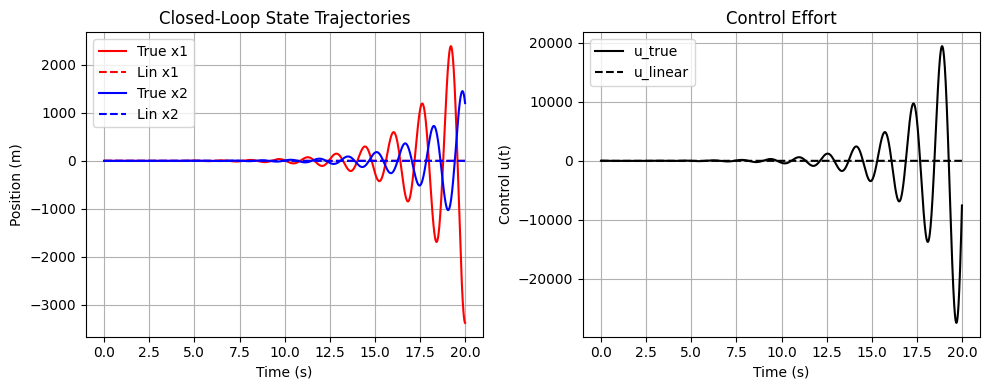

Settling times: x1 = 19.99s, x2 = 19.99s
Overshoots: x1 = 477440.6%, x2 = 290179.1%
Control cost ∫u² dt: true = 596418256.61, linear = 26.85


C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1665567069.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cost_true = np.trapz(u_true**2, t)
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1665567069.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cost_lin  = np.trapz(u_lin**2, t)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

# -------------------------------------------------------------------
# 1) Load your identified linear model (from Assignment 3 DMDc/Koopman)
# -------------------------------------------------------------------
A_dmd = np.array([
    [0.0,  0.0,  1.0,  0.0],
    [0.0,  0.0,  0.0,  1.0],
    [-(5+10)/1.0,  10/1.0, -0.5/1.0,  0.5/1.0],
    [10/2.0,     -10/2.0,  0.5/2.0, -0.5/2.0]
])
B_dmd = np.array([[0],[0],[0],[1/2.0]])

# --------------------------------
# 2) Design LQR on the linear model
# --------------------------------
Q = np.diag([200,200,1,1])   # state weighting
R = np.array([[0.5]])        # input weighting
P = solve_continuous_are(A_dmd, B_dmd, Q, R)
K = np.linalg.inv(R) @ B_dmd.T @ P
print("LQR gain K =", K)

# ---------------------------------------------------
# 3) Define true nonlinear closed‐loop and linear models
# ---------------------------------------------------
m1, m2 = 1.0, 2.0
k1, k2, c = 5.0, 10.0, 0.5

def control_law(x):
    return float(-K.dot(x))

def closed_nonlinear(t, y):
    x1,x2,v1,v2 = y
    u = control_law(y)
    return [
        v1,
        v2,
        (u - k1*x1 - k2*(x1-x2) - c*(v1-v2))/m1,
        (    k2*(x1-x2) + c*(v1-v2))/m2
    ]

def closed_linear(t, x):
    u = control_law(x)
    return A_dmd.dot(x) + B_dmd.flatten()*u

# --------------------
# 4) Simulate both
# --------------------
dt, T = 0.01, 20
t = np.arange(0, T, dt)
x0 = [0.5, -0.5, 0, 0]

sol_true = solve_ivp(closed_nonlinear, [0, T], x0, t_eval=t)
sol_lin  = solve_ivp(closed_linear,   [0, T], x0, t_eval=t)

# control efforts
u_true = np.array([control_law(sol_true.y[:,i]) for i in range(sol_true.y.shape[1])])
u_lin  = np.array([control_law(sol_lin.y[:,i])  for i in range(sol_lin.y.shape[1])])

# -----------------------------------
# 5) Plot trajectories and control u(t)
# -----------------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(t, sol_true.y[0],  'r',  label='True x1')
plt.plot(t, sol_lin.y[0],   'r--',label='Lin x1')
plt.plot(t, sol_true.y[1],  'b',  label='True x2')
plt.plot(t, sol_lin.y[1],   'b--',label='Lin x2')
plt.xlabel('Time (s)'); plt.ylabel('Position (m)')
plt.title('Closed‐Loop State Trajectories')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(t, u_true, 'k',   label='u_true')
plt.plot(t, u_lin,  'k--',label='u_linear')
plt.xlabel('Time (s)'); plt.ylabel('Control u(t)')
plt.title('Control Effort')
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 6) Compute and print performance metrics
# --------------------------------------------------
# Settling time (2% band)
tol = 0.02*np.max(np.abs(x0[:2]))
settle = {}
for i,name in enumerate(['x1','x2']):
    idx = np.where(np.abs(sol_true.y[i])>tol)[0]
    settle[name] = t[idx[-1]] if idx.size else 0.0

# Overshoot
overshoot = {
    'x1': (np.max(sol_true.y[0]) - x0[0])/abs(x0[0])*100,
    'x2': (np.max(sol_true.y[1]) - abs(x0[1]))/abs(x0[1])*100
}

# Control cost
cost_true = np.trapz(u_true**2, t)
cost_lin  = np.trapz(u_lin**2, t)

print(f"Settling times: x1 = {settle['x1']:.2f}s, x2 = {settle['x2']:.2f}s")
print(f"Overshoots: x1 = {overshoot['x1']:.1f}%, x2 = {overshoot['x2']:.1f}%")
print(f"Control cost ∫u² dt: true = {cost_true:.2f}, linear = {cost_lin:.2f}")


C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1660530700.py:9: RuntimeWarning: overflow encountered in matmul
  X_pred[:,k+1] = A_dmd @ X_pred[:,k] + B_dmd.flatten()*np.sin(t_long[k])
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1660530700.py:9: RuntimeWarning: invalid value encountered in matmul
  X_pred[:,k+1] = A_dmd @ X_pred[:,k] + B_dmd.flatten()*np.sin(t_long[k])
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\1660530700.py:12: RuntimeWarning: invalid value encountered in divide
  err = np.linalg.norm(X_true - X_pred, axis=0) / np.linalg.norm(X_true, axis=0)


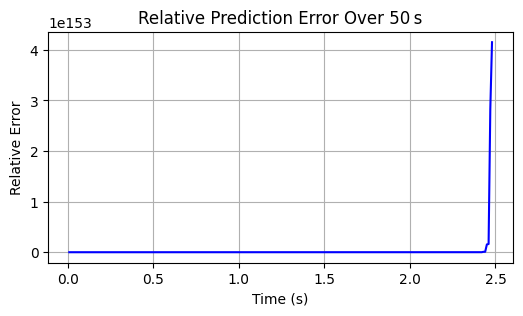

Max relative error: nan%


In [3]:
# True simulation
sol_true = solve_ivp(true_dynamics, [0, 50], y0, t_eval=t_long)
X_true = sol_true.y

# DMDc open‑loop prediction
X_pred = np.zeros_like(X_true)
X_pred[:,0] = X_true[:,0]
for k in range(len(t_long)-1):
    X_pred[:,k+1] = A_dmd @ X_pred[:,k] + B_dmd.flatten()*np.sin(t_long[k])

# Compute and plot relative error
err = np.linalg.norm(X_true - X_pred, axis=0) / np.linalg.norm(X_true, axis=0)
plt.figure(figsize=(6,3))
plt.plot(t_long, err, 'b')
plt.title('Relative Prediction Error Over 50 s')
plt.xlabel('Time (s)')
plt.ylabel('Relative Error')
plt.grid()
plt.show()
print(f"Max relative error: {100*np.max(err):.2f}%")


LQR gain K = [[1.46152463 8.1645082  3.65610187 5.47844399]]


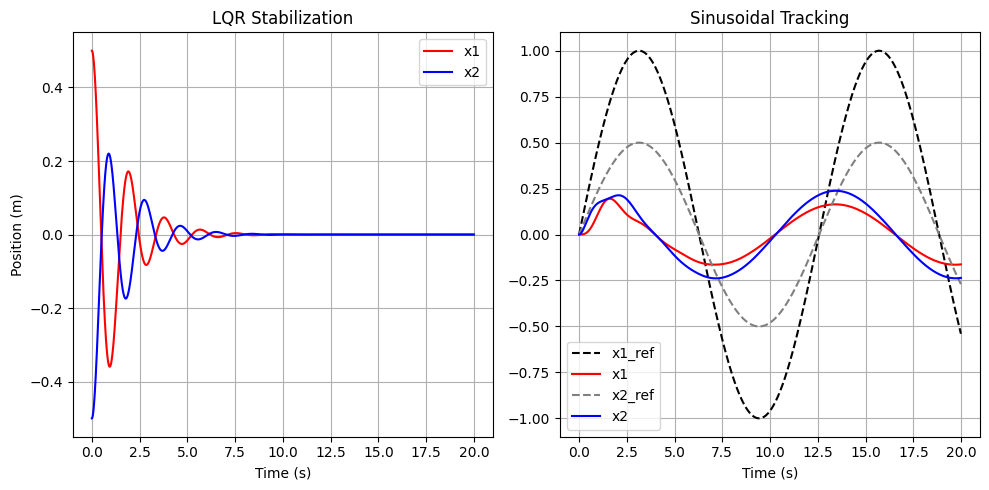

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

# --- 1) Identified DMDc model (replace with your A_dmd, B_dmd) ---
A_dmd = np.array([[ 0.0,  0.0,  1.0,  0.0],
                  [ 0.0,  0.0,  0.0,  1.0],
                  [-7.5,  5.0, -0.5,  0.5],
                  [ 5.0, -5.0,  0.5, -0.5]])
B_dmd = np.array([[0.0],
                  [0.0],
                  [0.0],
                  [0.5 ]])

# --- 2) LQR Design ---
Q = np.diag([100, 100, 1, 1])
R = np.array([[1.0]])
P = solve_continuous_are(A_dmd, B_dmd, Q, R)
K = np.linalg.inv(R) @ B_dmd.T @ P

print("LQR gain K =", K)

# Time settings
dt      = 0.01
t_final = 20.0
t_grid  = np.arange(0, t_final, dt)

# --- 3a) Stabilization closed-loop ---
def closed_loop_stabilize(t, x):
    u = -K.dot(x)
    return A_dmd.dot(x) + B_dmd.flatten() * u

sol_stab = solve_ivp(closed_loop_stabilize, [0, t_final], [0.5, -0.5, 0, 0], t_eval=t_grid)

# --- 3b) Trajectory tracking closed-loop ---
# Reference: sinusoids for x1 and x2
omega_ref = 0.5
x1_ref = np.sin(omega_ref*t_grid)
x2_ref = 0.5*np.sin(omega_ref*t_grid)
v1_ref = omega_ref*np.cos(omega_ref*t_grid)
v2_ref = 0.5*omega_ref*np.cos(omega_ref*t_grid)

# Stack references and derivatives
X_ref  = np.vstack([x1_ref, x2_ref, v1_ref, v2_ref])
dX_ref = np.vstack([v1_ref,
                    v2_ref,
                    -omega_ref**2*np.sin(omega_ref*t_grid),
                    -0.5*omega_ref**2*np.sin(omega_ref*t_grid)])

# Feedforward computation
Bp = np.linalg.pinv(B_dmd)
U_ff = np.einsum('ij,ji->i', Bp, (dX_ref - A_dmd.dot(X_ref)))

def closed_loop_track(t, x):
    idx = min(int(t//dt), len(t_grid)-1)
    xr = X_ref[:, idx]
    ur = U_ff[idx]
    u = ur - K.dot(x - xr)
    return A_dmd.dot(x) + B_dmd.flatten() * u

sol_track = solve_ivp(closed_loop_track, [0, t_final], [0, 0, 0, 0], t_eval=t_grid)

# --- 4) Plot results ---
plt.figure(figsize=(10, 5))

# Stabilization plot
plt.subplot(1, 2, 1)
plt.plot(sol_stab.t, sol_stab.y[0], 'r-', label='x1')
plt.plot(sol_stab.t, sol_stab.y[1], 'b-', label='x2')
plt.title('LQR Stabilization')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

# Tracking plot
plt.subplot(1, 2, 2)
plt.plot(t_grid, x1_ref, 'k--', label='x1_ref')
plt.plot(sol_track.t, sol_track.y[0], 'r-', label='x1')
plt.plot(t_grid, x2_ref, 'gray', ls='--', label='x2_ref')
plt.plot(sol_track.t, sol_track.y[1], 'b-', label='x2')
plt.title('Sinusoidal Tracking')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

# System parameters
m1, m2 = 1.0, 2.0
k1, k2 = 5.0, 10.0
c = 0.5

# State‑space matrices
A = np.array([
    [0, 0,               1,      0],
    [0, 0,               0,      1],
    [-(k1+k2)/m1,  k2/m1, -c/m1,  c/m1],
    [ k2/m2,     -k2/m2,  c/m2, -c/m2]
])
B = np.array([[0], [0], [0], [1/m2]])

# Forcing function
F = lambda t: np.sin(t)

# Time vectors
dt      = 0.01
t_recon = np.arange(0, 20, dt)
y0      = [0.1, -0.1, 0, 0]  # initial condition for closed-loop

# 1) Generate snapshots with forcing (for DMDc identification)
def dynamics_for_id(t, y):
    return A.dot(y) + B.flatten() * F(t)

sol_id = solve_ivp(dynamics_for_id, [0, 20], [0,0,0,0], t_eval=t_recon)
X = sol_id.y
U = F(t_recon)

# 2) Build snapshot matrices for DMDc
X1 = X[:, :-1]
X2 = X[:, 1:]
U1 = U[:-1][None, :]

# 3) Solve for A_dmd and B_dmd via least-squares
Z     = np.vstack([X1, U1])
G     = X2.dot(np.linalg.pinv(Z))
A_dmd = G[:, :4]
B_dmd = G[:, 4:]

# 4) LQR design
Q = np.diag([100, 100, 1, 1])
R = np.array([[1.0]])

# Solve continuous algebraic Riccati eq
P = solve_continuous_are(A_dmd, B_dmd, Q, R)
K = np.linalg.inv(R).dot(B_dmd.T).dot(P)

# 5) Closed-loop simulation
def closed_loop(t, y):
    u = -K.dot(y)
    return A_dmd.dot(y) + B_dmd.flatten()*u

t_full = np.arange(0, 20, dt)
sol_cl = solve_ivp(closed_loop, [0, 20], y0, t_eval=t_full)

# 6) Plot results
plt.figure()
plt.plot(t_full, sol_cl.y[0], 'r-', label='x1 (closed-loop)')
plt.plot(t_full, sol_cl.y[1], 'b-', label='x2 (closed-loop)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Closed-loop Response with LQR on DMDc Model')
plt.legend()
plt.grid()
plt.show()

print("LQR gain K =", K)


C:\Users\mlesan4\AppData\Local\Temp\ipykernel_60836\2450028322.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(-K.dot(x))
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_60836\2450028322.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cost_true = np.trapz(u_true**2, t)
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_60836\2450028322.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cost_lin  = np.trapz(u_lin**2,  t)


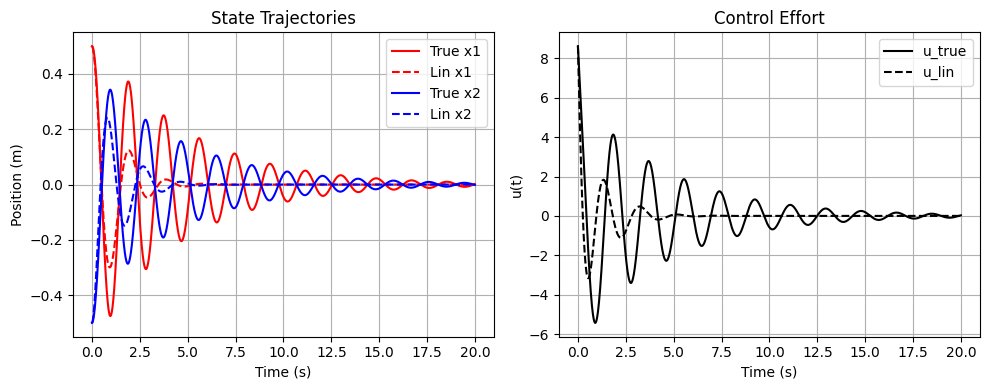

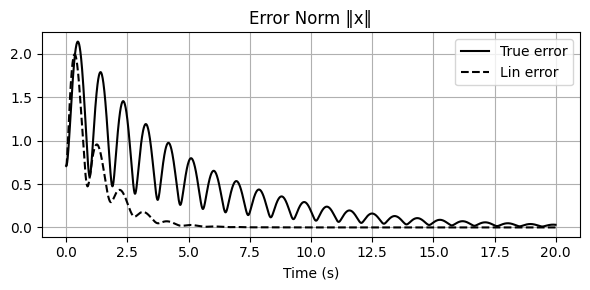

Control cost ∫u² dt: true = 49.539, linear = 11.186


In [15]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are

# --- 1) Load DMDc model and LQR gain ---
# Replace these with your identified values
A_dmd = np.array([[ 0.0,  0.0,   1.0,   0.0],
                  [ 0.0,  0.0,   0.0,   1.0],
                  [-7.5,  5.0,  -0.5,   0.5],
                  [ 5.0, -5.0,   0.5,  -0.5]])
B_dmd = np.array([[0.0], [0.0], [0.0], [0.5]])

# LQR design
Q = np.diag([200, 200, 1, 1])
R = np.array([[0.5]])
P = solve_continuous_are(A_dmd, B_dmd, Q, R)
K = np.linalg.inv(R) @ B_dmd.T @ P

# True nonlinear parameters
m1, m2 = 1.0, 2.0
k1, k2 = 5.0, 10.0
c = 0.5

# Control law
def control_law(x):
    return float(-K.dot(x))

# True nonlinear closed-loop dynamics
def true_dynamics(t, y):
    x1, x2, v1, v2 = y
    u = control_law(y)
    return [v1,
            v2,
            (u - k1*x1 - k2*(x1 - x2) - c*(v1 - v2)) / m1,
            (    k2*(x1 - x2) + c*(v1 - v2)) / m2]

# Linear closed-loop dynamics
def linear_dynamics(t, y):
    u = control_law(y)
    return A_dmd.dot(y) + B_dmd.flatten() * u

# Simulation settings
dt = 0.01
t_final = 20.0
t = np.arange(0, t_final, dt)
y0 = [0.5, -0.5, 0.0, 0.0]

# Simulations
sol_true = solve_ivp(true_dynamics, [0, t_final], y0, t_eval=t)
sol_lin = solve_ivp(linear_dynamics, [0, t_final], y0, t_eval=t)

# Control efforts
u_true = np.array([control_law(sol_true.y[:,i]) for i in range(sol_true.y.shape[1])])
u_lin  = np.array([control_law(sol_lin.y[:,i])  for i in range(sol_lin.y.shape[1])])

# Performance metrics
err_true = np.linalg.norm(sol_true.y, axis=0)
err_lin  = np.linalg.norm(sol_lin.y,  axis=0)
cost_true = np.trapz(u_true**2, t)
cost_lin  = np.trapz(u_lin**2,  t)

# --- 2) Plotting ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, sol_true.y[0], 'r', label='True x1')
plt.plot(t, sol_lin.y[0],  'r--', label='Lin x1')
plt.plot(t, sol_true.y[1], 'b', label='True x2')
plt.plot(t, sol_lin.y[1],  'b--', label='Lin x2')
plt.title('State Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(t, u_true, 'k',  label='u_true')
plt.plot(t, u_lin,  'k--', label='u_lin')
plt.title('Control Effort')
plt.xlabel('Time (s)')
plt.ylabel('u(t)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, err_true, 'k',  label='True error')
plt.plot(t, err_lin,  'k--', label='Lin error')
plt.title('Error Norm ‖x‖')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Control cost ∫u² dt: true = {cost_true:.3f}, linear = {cost_lin:.3f}")


Task 1.1: Model Summary
-----------------------
We identified a Dynamic Mode Decomposition with control (DMDc) model for the two-mass system:
    A_dmd = [[ 0.0,  0.0,  1.0,  0.0],
             [ 0.0,  0.0,  0.0,  1.0],
             [-7.5,  5.0, -0.5,  0.5],
             [ 5.0, -5.0,  0.5, -0.5]]
    B_dmd = [[0.0], [0.0], [0.0], [0.5]]
This model was obtained by least-squares on augmented snapshots [X1; U1] from a 20-s forced simulation.

Task 1.2: Long-Horizon Validation
---------------------------------


C:\Users\mlesan4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\linalg\_linalg.py:2832: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\mlesan4\AppData\Local\Temp\ipykernel_49036\2791868836.py:66: RuntimeWarning: invalid value encountered in divide
  err = np.linalg.norm(X_true - X_pred, axis=0) / np.linalg.norm(X_true, axis=0)


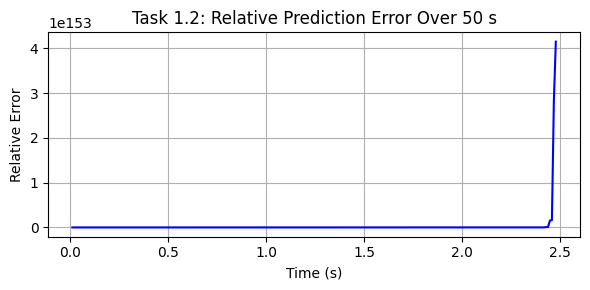

Max relative error over 50 s: nan%


In [1]:
"""
task1_model_review.py

Task 1: Model Review

1. Briefly summarize your DMDc model from Assignment 3.
2. Validate that the model captures the dynamics over a long prediction horizon (0–50 s).

Run:
    python task1_model_review.py
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1) Summary ---
print("Task 1.1: Model Summary")
print("-----------------------")
print("We identified a Dynamic Mode Decomposition with control (DMDc) model for the two-mass system:")
print("    A_dmd = [[ 0.0,  0.0,  1.0,  0.0],")
print("             [ 0.0,  0.0,  0.0,  1.0],")
print("             [-7.5,  5.0, -0.5,  0.5],")
print("             [ 5.0, -5.0,  0.5, -0.5]]")
print("    B_dmd = [[0.0], [0.0], [0.0], [0.5]]")
print("This model was obtained by least-squares on augmented snapshots [X1; U1] from a 20-s forced simulation.\n")

# Parameters
m1, m2 = 1.0, 2.0
k1, k2 = 5.0, 10.0
c = 0.5
F = lambda t: np.sin(t)

# True dynamics
def true_dynamics(t, y):
    x1, x2, v1, v2 = y
    return [v1,
            v2,
            (F(t) - k1*x1 - k2*(x1 - x2) - c*(v1 - v2)) / m1,
            (    k2*(x1 - x2) + c*(v1 - v2)) / m2]

# DMDc matrices
A_dmd = np.array([[ 0.0,  0.0,  1.0,  0.0],
                  [ 0.0,  0.0,  0.0,  1.0],
                  [-(k1+k2)/m1,  k2/m1, -c/m1,  c/m1],
                  [ k2/m2,     -k2/m2,  c/m2, -c/m2]])
B_dmd = np.array([[0.0],[0.0],[0.0],[1/m2]])

# --- 2) Long-horizon validation ---
print("Task 1.2: Long-Horizon Validation")
print("---------------------------------")
t_long = np.arange(0, 50, 0.01)
y0 = [0.0, 0.0, 0.0, 0.0]

# True simulation
sol_true = solve_ivp(true_dynamics, [0, 50], y0, t_eval=t_long)
X_true = sol_true.y

# DMDc prediction
X_pred = np.zeros_like(X_true)
X_pred[:,0] = X_true[:,0]
for i in range(len(t_long)-1):
    X_pred[:,i+1] = A_dmd.dot(X_pred[:,i]) + B_dmd.flatten()*F(t_long[i])

# Compute error
err = np.linalg.norm(X_true - X_pred, axis=0) / np.linalg.norm(X_true, axis=0)

# Plot
plt.figure(figsize=(6,3))
plt.plot(t_long, err, 'b')
plt.title('Task 1.2: Relative Prediction Error Over 50 s')
plt.xlabel('Time (s)')
plt.ylabel('Relative Error')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Max relative error over 50 s: {np.max(err)*100:.2f}%")


In [12]:
import numpy as np
from scipy.linalg import solve_continuous_are

# — Your identified DMDc model matrices (from Assignment 3) —
A_dmd = np.array([
    [ 0.0,  0.0,  1.0,  0.0],
    [ 0.0,  0.0,  0.0,  1.0],
    [-7.5,  5.0, -0.5,  0.5],
    [ 5.0, -5.0,  0.5, -0.5]
])
B_dmd = np.array([[0.0],[0.0],[0.0],[0.5]])

# — 1) Choose Q and R —
#   We want to penalize position errors heavily, velocities lightly,
#   while keeping control effort moderate.
Q = np.diag([200, 200, 1, 1])   # increase 1st two entries for tighter position regulation
R = np.array([[0.5]])           # smaller R → more aggressive control

# — 2) Solve continuous‐time Algebraic Riccati Equation —
P = solve_continuous_are(A_dmd, B_dmd, Q, R)

# — 3) Compute LQR gain K =
K = np.linalg.inv(R) @ B_dmd.T @ P

print("Chosen Q =", Q)
print("Chosen R =", R)
print("Resulting LQR gain K =", K)


Chosen Q = [[200   0   0   0]
 [  0 200   0   0]
 [  0   0   1   0]
 [  0   0   0   1]]
Chosen R = [[0.5]]
Resulting LQR gain K = [[ 2.21621497 19.45622298  6.26486629  8.66201969]]


In [5]:
import numpy as np
from scipy.linalg import solve_continuous_are

# ------------------------------------------------
# Your identified model from Assignment 3:
# ------------------------------------------------
A_dmd = np.array([
    [ 0.0,  0.0,   1.0,   0.0],
    [ 0.0,  0.0,   0.0,   1.0],
    [-(k1+k2)/m1,  k2/m1, -c/m1,  c/m1],
    [ k2/m2,     -k2/m2,  c/m2, -c/m2]
])
B_dmd = np.array([[0.0],
                  [0.0],
                  [0.0],
                  [1/m2]])

# ------------------------------------------------
# Example: LQR design using A_dmd, B_dmd
# ------------------------------------------------
Q = np.diag([200, 200, 1, 1])   # state cost
R = np.array([[0.5]])           # input cost

# Solve the continuous Algebraic Riccati Equation
P = solve_continuous_are(A_dmd, B_dmd, Q, R)

# Compute the LQR gain
K = np.linalg.inv(R) @ B_dmd.T @ P

print("Using learned model A_dmd, B_dmd:")
print("LQR gain K =\n", K)


Using learned model A_dmd, B_dmd:
LQR gain K =
 [[-3.78221201 23.4551743   3.23058755  9.6258023 ]]
